### Goal

Model the gene expression imputation using not only the individual effect (PCA over the genes) but also gene effect (PCA over samples in the training set).

### TODO
1. Data
2. Compute P
3. Compute Q
4. Linear regression
5. Run linear regression across top 10 tissues
6. Evaluate models
7. Y_true, Y_pred correlation plot for blood to muscle inference
8. Keras model + evaluate model

### Conclusions

Computing the mean over the pearson/spearman correlation over the 20000 it might be to generalized.<br/>
Suggestion would be choose the top 100 correlating genes and stick to them for further evaluation.

---

In [1]:
import seaborn as sns
import comet_ml
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.externals import joblib
import sklearn as sk
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LassoLarsCV, LinearRegression, RidgeCV, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import spearmanr, pearsonr

np.random.seed(1)

from keras.layers import Input, Dense, Add
from keras.models import Model
from keras.optimizers import Adam

from scipy.stats import spearmanr, pearsonr


import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import warnings; warnings.simplefilter('ignore')

np.random.seed(1)

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [4]:
# top candidates

top_individuals = ['GTEX-ZAB4',
                    'GTEX-12WSD',
                     'GTEX-13OW6',
                     'GTEX-131YS',
                     'GTEX-NPJ8',
                     'GTEX-11GSP',
                     'GTEX-YFC4',
                     'GTEX-13OVJ',
                     'GTEX-13OW8',
                     'GTEX-12ZZX']
top_highvariance_genes = ['ENSG00000171195.10',
                         'ENSG00000124233.11',
                         'ENSG00000169344.15',
                         'ENSG00000172179.11',
                         'ENSG00000259384.6',
                         'ENSG00000204414.11',
                         'ENSG00000279857.1',
                         'ENSG00000135346.8',
                         'ENSG00000164822.4',
                         'ENSG00000164816.7']
top_lowvariance_genes = ['ENSG00000262526.2',
                         'ENSG00000131143.8',
                         'ENSG00000173812.10',
                         'ENSG00000104904.12',
                         'ENSG00000170315.13',
                         'ENSG00000105185.11',
                         'ENSG00000123349.13',
                         'ENSG00000156976.15',
                         'ENSG00000197746.13',
                         'ENSG00000172757.12']
top_tissues = ['Muscle - Skeletal',
             'Skin - Sun Exposed (Lower leg)',
             'Adipose - Subcutaneous',
             'Lung',
             'Artery - Tibial',
             'Thyroid',
             'Nerve - Tibial',
             'Esophagus - Mucosa',
             'Cells - Transformed fibroblasts',
             'Esophagus - Muscularis',
             'Heart - Left Ventricle',
             'Skin - Not Sun Exposed (Suprapubic)',
             'Artery - Aorta',
             'Adipose - Visceral (Omentum)']

### 1. Data


In [2]:
# load train valida data
path = "/s/project/rep/"
# path = "/home/mada/Uni/Masterthesis/online_repo/rep/data/"
y_targets_h5 = path + "processed/gtex/input_data/Y_targets_pc_onlyblood.h5"
x_inputs_h5 =  path + "processed/gtex/input_data/X_inputs_pc_onlyblood.h5"
train_dataset, valid_dataset = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

metadata_samples_train, metadata_samples_valid = train_dataset.metadata, valid_dataset.metadata
features_train, features_valid = train_dataset.features, valid_dataset.features
x_train, y_train = train_dataset.inputs, train_dataset.targets
x_valid, y_valid = valid_dataset.inputs, valid_dataset.targets

# load gtex data
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)

valid_individuals_file = path + "processed/gtex/recount/valid_individuals.txt"
valid_individuals = prep.read_csv_one_column(valid_individuals_file)

gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered = gtex[gtex.samples['Individual'].isin(train_individuals + valid_individuals)]
gtex_filtered_train = gtex[gtex.samples['Individual'].isin(train_individuals)]
del gtex

In [5]:
gdf=gtex_filtered_train.var
top_highvariance_genes_index = np.where(gdf['gene_id'].isin(top_highvariance_genes))[0]
top_lowvariance_genes_index = np.where(gdf['gene_id'].isin(top_lowvariance_genes))[0]
top_highvariance_genes_symbol = gdf[gdf['gene_id'].isin(top_highvariance_genes)]['symbol'].tolist()
top_lowvariance_genes_symbol = gdf[gdf['gene_id'].isin(top_lowvariance_genes)]['symbol'].tolist()


### 2. Compute $P$ = PCA individual effect (all individuals in train and valid in blood)
   - input $X$: dim($X$) = #indiv x #genes (only blood)<br/>
   - output $P$: dim($P$) = #indiv x #n_comp<br/>

In [87]:
# compute PCA - perform this
def pca_individual_effect(gtex, n_comp = 10, tissue = 'Whole Blood', pca_type = PCA):
    slice_blood = gtex[gtex.obs['Tissue'] == tissue]
    metadata = slice_blood.obs
    features = slice_blood.X
    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    return pca, features_pca

%time pca_individual_effect_model, P = pca_individual_effect(gtex_filtered)

CPU times: user 15.2 s, sys: 3.67 s, total: 18.8 s
Wall time: 599 ms


In [88]:
pca_individual_effect_model.components_.shape, P.shape

((10, 19932), (331, 10))


### 3. Compute  $Q$  = PCA gene effect (all individuals in train and valid in blood)
   - input  $X^T$ : dim( $X^T$ ) = #genes x #samples (training set, all tissues) <br/>
   - output  $Q$ : dim( $Q$ ) = #genes x #n_comp <br/>

In [89]:
# compute PCA
def pca_gene_effect(gtex, n_comp = 10, pca_type = PCA):
    features = gtex.X.transpose()
    print(features.shape)
    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    return pca, features_pca

%time pca_gene_effect_model, Q = pca_gene_effect(gtex_filtered_train)

(19932, 5389)
CPU times: user 1min 3s, sys: 7.74 s, total: 1min 11s
Wall time: 5.52 s


In [90]:
del gtex_filtered_train, gtex_filtered

In [91]:
pca_gene_effect_model.components_.shape

(10, 5389)

### 4. Linear regression
Compute : $Y_i,g,k=X_i,g,k * P_k_i * alpha_k + Q_g_l * beta_l + epsilon_i,g,k + beta_k$, i=individual, g=gene, k=tissue.

In [12]:
%%latex
Design matrix will look like 
\[
M=\begin{bmatrix}
    P_{i_1} & Q_{g_1} & OneHotEnc(tissue) \\
    P_{i_1} & Q_{g_2} & OneHotEnc(tissue)\\
    ... && \\
    P_{i_2} & Q_{g_1} & OneHotEnc(tissue) \\
    P_{i_2} & Q_{g_2} & OneHotEnc(tissue)\\
    ...
\end{bmatrix}
\]

,where dim(P) = 1 x n_comp for individual $i$, dim(Q_{g_n}) = 1 x n_comp for gene g_n

<IPython.core.display.Latex object>

In [38]:
def linear_regression(X_reg_indiv, X_reg_gene, y):
    
    y_indiv_effect = 0
    y_gene_effect = 0

    reg_indiv = LinearRegression()
    reg_genes = LinearRegression(fit_intercept=False)

    alphas = np.zeros(P.shape[1])
    betas = np.zeros(Q.shape[1])
    
    stop = 0
    
    while(stop < 2):
        
        stop = 0
        ######################## gene effect ###########################  

        # fit without intercept
        reg_genes.fit(X_reg_gene, y - y_indiv_effect)
        if np.isclose(betas, reg_genes.coef_).any():
            stop += 1
        betas =  reg_genes.coef_
        
         # predict
        y_gene_effect = reg_genes.predict(X_reg_gene)        
               
        ####################### individual effect ####################    

        # fit with intercept (this is the beta_0)
        reg_indiv.fit(X_reg_indiv, y - y_gene_effect)  
        if np.isclose(alphas, reg_indiv.coef_).any():
            stop += 1 
        alphas =  reg_indiv.coef_
        beta_zero = reg_indiv.intercept_        
       
        # predict
        y_indiv_effect = reg_indiv.predict(X_reg_indiv)

        y_pred = y_gene_effect + y_indiv_effect
        
    
    return (reg_genes, reg_indiv)

def linear_regression_bigmodel(X_reg_indiv, X_reg_gene, y):
    reg = LinearRegression()
    X = np.concatenate((X_reg_indiv, X_reg_gene), axis=1)
    reg.fit(X,y)    
    return reg
    

def predict_lm(X_reg_indiv, X_reg_gene, reg_genes, reg_indiv):    
    return reg_genes.predict(X_reg_gene) + reg_indiv.predict(X_reg_indiv)


def predict_lm_bigmodel(X_reg_indiv, X_reg_gene, reg):
    X = np.concatenate((X_reg_indiv, X_reg_gene), axis=1)
    return reg.predict(X)


def transform_gene_effect_input(x, indiv_times):
    # Flatten data
    # g=1 indiv1 Q1
    #     indiv2 Q1
    #     indiv3 Q1
    #....
    # g=2 indiv1 Q2
    #     indiv2 Q2
    
    return np.tile(x,(indiv_times,1))
    
#     x = np.tile(Q[0,:],(indiv_times,1))
#     for i in range(1,g_times):
#         x = np.append(x, np.tile(Q[i,:],(indiv_times,1)), axis=0)
#     return x


def transform_indiv_effect_input(x, indiv_times, g_times):
    # Flatten data
    # g=1 indiv1 P1
    #     indiv2 P2
    #     indiv3 P3
    #....
    # g=2 indiv1 P1
    #     indiv2 P2
#     return np.tile(x,(g_times,1))

    x = np.tile(P[0,:],(g_times,1))
    for i in range(1,indiv_times):
        x = np.append(x, np.tile(Q[i,:],(g_times,1)), axis=0)
    return x
    

def get_linear_regression_data(tissue, mt_train, mt_valid, x_train, y_train, x_valid, y_valid):
    # Normalize Data
    index_train = np.where(mt_train['To_tissue'] == tissue)[0]
    index_valid = np.where(mt_valid['To_tissue'] == tissue)[0]

    xs_train = x_train[index_train,:]
    xs_valid = x_train[index_valid,:]
    ys_train = y_train[index_train,:]
    ys_valid = y_valid[index_valid,:]
#     st_x = StandardScaler()
#     xs_train = st_x.fit_transform(x_train[index_train,:])
#     xs_valid = st_x.transform(x_valid[index_valid,:])

#     st_y = StandardScaler()
#     ys_train = st_y.fit_transform(y_train[index_train,:])
#     ys_valid = st_y.transform(y_valid[index_valid,:])
    
    print(f'shape y_train {ys_train.shape}; shape y_valid {ys_valid.shape}')

    # PCA transform of input data
    xs_pca_train = pca_individual_effect_model.transform(xs_train)
    xs_pca_valid = pca_individual_effect_model.transform(xs_valid)
    
    # Y train
    # train samples - ys_train = indiv x genes
    y = ys_train.flatten()
    yv = ys_valid.flatten()

    g_times = Q.shape[0]
    
    indiv_times = xs_pca_train.shape[0]
    # X train  - individual effect
    # repeat P matrix g-times
    X_reg_indiv_train = transform_indiv_effect_input(xs_pca_train, indiv_times, g_times)
    # X train - gene effect
    # repeat Q matrix such invididuals x gene_i, i = 0,20000
    X_reg_gene_train = transform_gene_effect_input(Q, indiv_times)
    
    
    indiv_times = xs_pca_valid.shape[0]
    X_reg_indiv_valid = transform_indiv_effect_input(xs_pca_valid, indiv_times, g_times)
    X_reg_gene_valid = transform_gene_effect_input(Q, indiv_times)
    
#     print(f'shape y {y.shape}; shape yv {yv.shape}; X_reg_indiv_train shape {X_reg_indiv_train.shape}; X_reg_gene_train shape {X_reg_gene_train.shape}')
   
    return (y, X_reg_indiv_train, X_reg_gene_train), (yv, X_reg_indiv_valid, X_reg_gene_valid)


### 5. Run Linear Model per tissue

<br/>
Number of available samples for training per tissue (Top 10 tissues).

In [92]:
count_samples = metadata_samples_train[['From_tissue','To_tissue']].groupby('To_tissue').count().sort_values('From_tissue',ascending=False)[:30]
count_samples

,From_tissue
To_tissue,
Muscle - Skeletal,220
Skin - Sun Exposed (Lower leg),193
Adipose - Subcutaneous,189
Lung,183
Artery - Tibial,181
Cells - Transformed fibroblasts,179
Nerve - Tibial,164
Thyroid,162
Esophagus - Mucosa,154


In [93]:
tissues = count_samples.index[:10]

In [94]:
def pearson(y_true, y_pred, tissue):
    pr = []
    for i in range(y_true.shape[1]):
        pr.append(pearsonr(y_true[:,i], y_pred[:,i])[0]) 
    pr = np.array(pr)
    pr = pr[~np.isnan(pr)]
    return {'value':np.mean(pr), 
            'tissue':tissue,
            'metric':'pearson'
           }

def spearman(y_true, y_pred, tissue):
    pr = []
    for i in range(y_true.shape[1]):
        pr.append(spearmanr(y_true[:,i], y_pred[:,i])[0]) 
    pr = np.array(pr)
    pr = pr[~np.isnan(pr)]
    print(f'max pearson: {np.max(pr)}')
    return {'value':np.mean(pr), 
            'tissue':tissue,
            'metric':'spearman'
           }


In [60]:
evaluation = pd.DataFrame(columns=['value','metric','tissue'])
evaluation_bigmodel = pd.DataFrame(columns=['value','metric','tissue'])

# lm_trained = {}
lm_trained_bigmodel = {}


for t in tissues:
    print(f'Run linear model for tissue {t}')
    # get input data
    (y, X_reg_indiv_train, X_reg_gene_train), (yv, X_reg_indiv_valid, X_reg_gene_valid) = get_linear_regression_data(t,
                                                                                                                      metadata_samples_train,
                                                                                                                      metadata_samples_valid,
                                                                                                                      x_train,
                                                                                                                      y_train,
                                                                                                                      x_valid,
                                                                                                                      y_valid)
    # fit model
    print("Fit...")
    (lm_genes, lm_indiv) = linear_regression(X_reg_indiv_train, X_reg_gene_train, y)
#     lm_trained[t] = (lm_genes, lm_indiv)
    y_pred = predict_lm(X_reg_indiv_valid, X_reg_gene_valid, lm_genes, lm_indiv)
    
    performance = pearson(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)
    evaluation = evaluation.append(performance,ignore_index=True)
    performance = spearman(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)
    evaluation = evaluation.append(performance,ignore_index=True)

    
    
    # fit big model
    lm_big = linear_regression_bigmodel(X_reg_indiv_train, X_reg_gene_train, y)
    lm_trained_bigmodel[t] = lm_big
    y_pred = predict_lm_bigmodel(X_reg_indiv_valid, X_reg_gene_valid, lm_big)
    
    performance = pearson(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)
    evaluation_bigmodel = evaluation_bigmodel.append(performance,ignore_index=True)
    performance = spearman(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)
    evaluation_bigmodel = evaluation_bigmodel.append(performance,ignore_index=True)



Run linear model for tissue Muscle - Skeletal
shape y_train (220, 19932); shape y_valid (83, 19932)
shape y (4385040,); shape yv (1654356,); X_reg_indiv_train shape (4385040, 10); X_reg_gene_train shape (4385040, 10)
Fit...
max pearson: 0.3458068986250386
max pearson: 0.3458068986250386
Run linear model for tissue Skin - Sun Exposed (Lower leg)
shape y_train (193, 19932); shape y_valid (74, 19932)
shape y (3846876,); shape yv (1474968,); X_reg_indiv_train shape (3846876, 10); X_reg_gene_train shape (3846876, 10)
Fit...
max pearson: 0.46853571563680757
max pearson: 0.46853571563680757
Run linear model for tissue Adipose - Subcutaneous
shape y_train (189, 19932); shape y_valid (81, 19932)
shape y (3767148,); shape yv (1614492,); X_reg_indiv_train shape (3767148, 10); X_reg_gene_train shape (3767148, 10)
Fit...
max pearson: 0.3748447283713114
max pearson: 0.3748447283713114
Run linear model for tissue Lung
shape y_train (183, 19932); shape y_valid (81, 19932)
shape y (3647556,); shape yv 

### 6. Evaluate of the big/iterative model - mean Pearson/Spearman Corr across 20000 genes

Iterative model

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

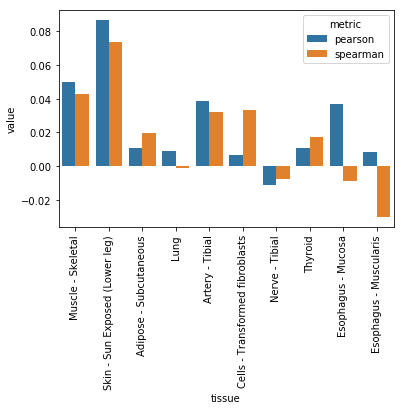

In [55]:
ax = sns.barplot(x="tissue", y="value", hue="metric", data=evaluation)
plt.xticks(rotation=90)

Big model

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

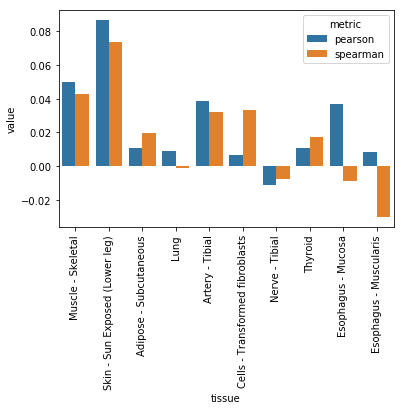

In [58]:
ax = sns.barplot(x="tissue", y="value", hue="metric", data=evaluation_bigmodel)
plt.xticks(rotation=90)

### 7. Plot linear regression results for blood to muscle prediction

In [90]:
t='Heart - Left Ventricle'
(y, X_reg_indiv_train, X_reg_gene_train), (yv, X_reg_indiv_valid, X_reg_gene_valid) = get_linear_regression_data(t,
                                                                                                                      metadata_samples_train,
                                                                                                                      metadata_samples_valid,
                                                                                                                      x_train,
                                                                                                                      y_train,
                                                                                                                      x_valid,
                                                                                                                      y_valid)

shape y_train (143, 19932); shape y_valid (47, 19932)
shape y (2850276,); shape yv (936804,); X_reg_indiv_train shape (2850276, 10); X_reg_gene_train shape (2850276, 10)


In [108]:
# train data
y_true_2d = y.reshape(-1,Q.shape[0])
y_pred_2d = lm_trained_bigmodel[t].predict(np.concatenate((X_reg_indiv_train, X_reg_gene_train), axis=1)).reshape(-1,Q.shape[0])

top = []
for i in range(Q.shape[0]): 
    if spearmanr(y_true_2d[:, i],y_pred_2d[:, i])[0] > 0.32:
        top.append(i)

In [104]:
top = [2539, 2881, 3378, 7532, 9306, 9544, 14870, 15125, 19293]

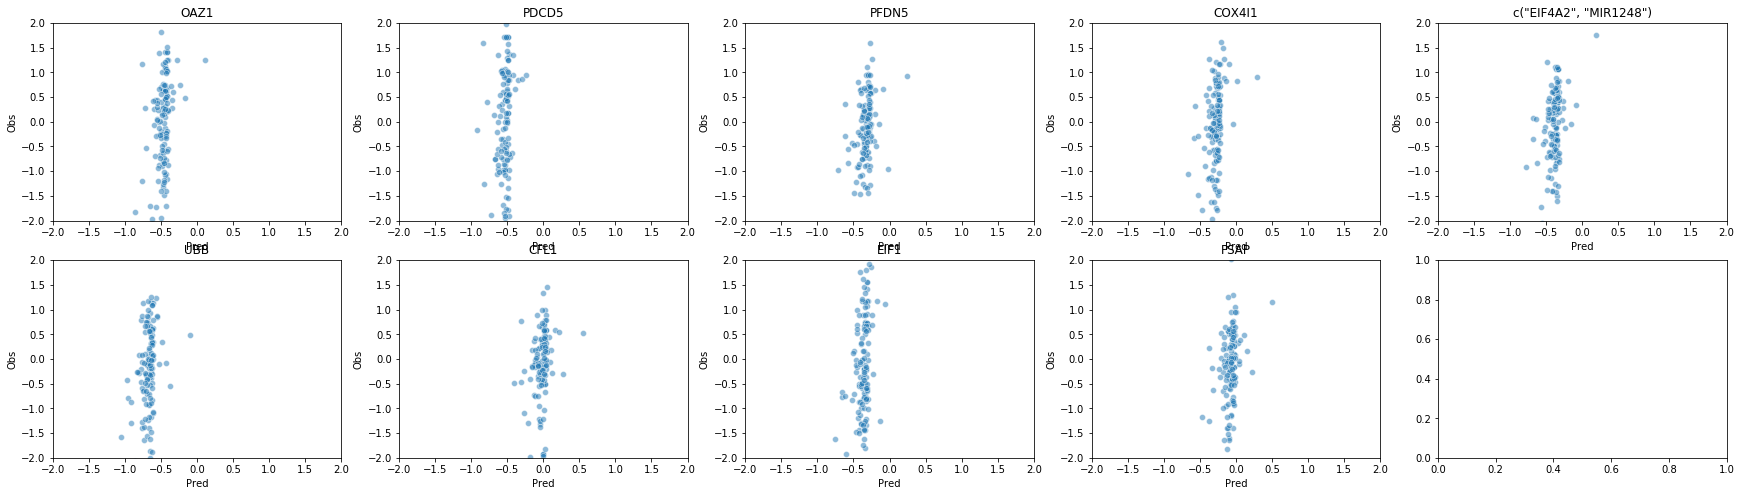

In [112]:
f, axes = plt.subplots(2, 5,figsize=(30,8))
# low variance genes
# for i in range(5): 
#     index = top_highvariance_genes_index[i]
#     ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true_2d[:, index],'pred':y_pred_2d[:, index]}, ax = axes[0][int(i%5)], alpha = 0.5)
#     ax.set(ylim=(-5,5), xlim=(-5,5), xlabel='Pred',ylabel='Obs',title=top_highvariance_genes_symbol[i])
# high variance genes
for i in range(len(top)):    
#     index = top_lowvariance_genes_index[i]
    index = top[i]

    ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true_2d[:, index],'pred':y_pred_2d[:, index]}, ax = axes[int(i/5)][int(i%5)], alpha = 0.5)
    ax.set(ylim=(-2,2), xlim=(-2,2), xlabel='Pred',ylabel='Obs',title=top_lowvariance_genes_symbol[i])

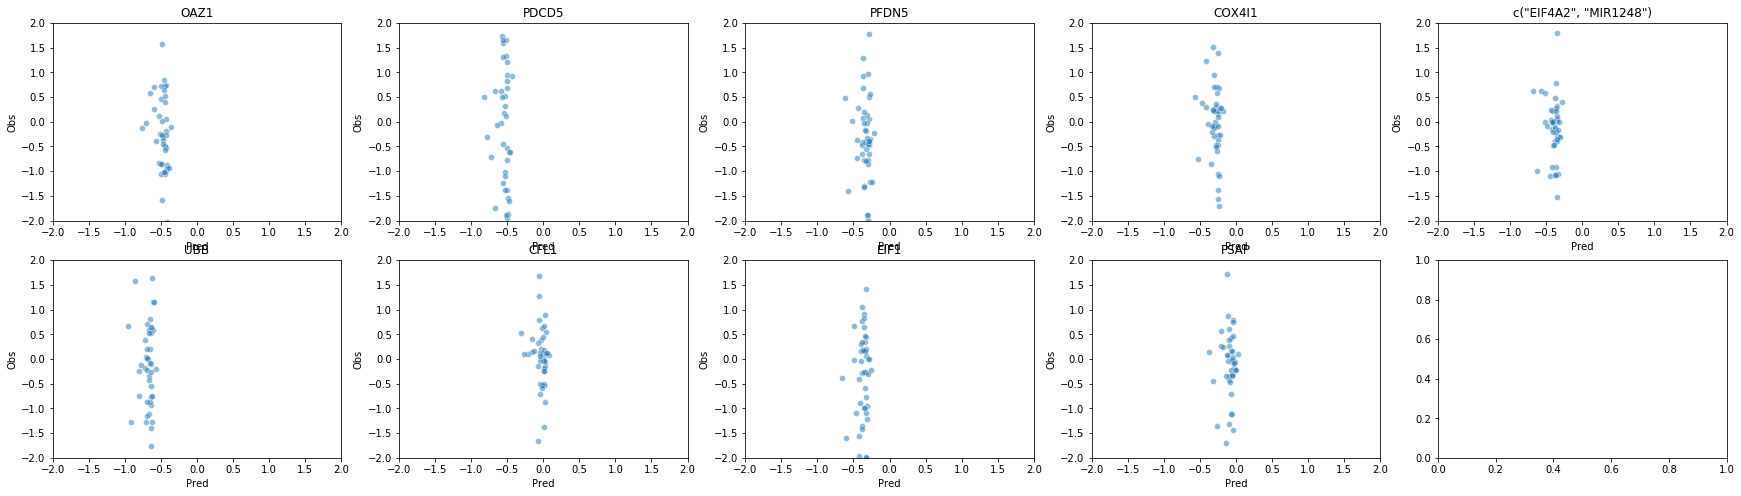

In [113]:
# valid data
y_true_2d = yv.reshape(-1,Q.shape[0])
y_pred_2d = lm_trained_bigmodel[t].predict(np.concatenate((X_reg_indiv_valid, X_reg_gene_valid), axis=1)).reshape(-1,Q.shape[0])

f, axes = plt.subplots(2, 5,figsize=(30,8))
# low variance genes
# for i in range(5): 
#     index = top_highvariance_genes_index[i]
#     ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true_2d[:, index],'pred':y_pred_2d[:, index]}, ax = axes[0][int(i%5)], alpha = 0.5)
#     ax.set(ylim=(-5,5), xlim=(-5,5), xlabel='Pred',ylabel='Obs',title=top_highvariance_genes_symbol[i])
# high variance genes
for i in range(len(top)):    
#     index = top_lowvariance_genes_index[i]
    index = top[i]
    ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true_2d[:, index],'pred':y_pred_2d[:, index]}, ax = axes[int(i/5)][int(i%5)], alpha = 0.5)
    ax.set(ylim=(-2,2), xlim=(-2,2), xlabel='Pred',ylabel='Obs',title=top_lowvariance_genes_symbol[i])

### 8. Implement the gene_effect + individual_effect using a keras

In [95]:
def data(tissue):
    # Normalize Data
    index_train = np.where(metadata_samples_train['To_tissue'] == tissue)[0]
    index_valid = np.where(metadata_samples_valid['To_tissue'] == tissue)[0]
    
    xs_train = x_train[index_train,:]
    xs_valid = x_train[index_valid,:]
    ys_train = y_train[index_train,:]
    ys_valid = y_valid[index_valid,:]

#     st_x = StandardScaler()
#     xs_train = st_x.fit_transform(x_train[index_train,:])
#     xs_valid = st_x.transform(x_valid[index_valid,:])

#     st_y = StandardScaler()
#     ys_train = st_y.fit_transform(y_train[index_train,:])
#     ys_valid = st_y.transform(y_valid[index_valid,:])
    
    print(f'shape y_train {ys_train.shape}; shape y_valid {ys_valid.shape}')

    # PCA transform of input data
    xs_pca_train = pca_individual_effect_model.transform(xs_train)
    xs_pca_valid = pca_individual_effect_model.transform(xs_valid)
    
    # Y train
    # train samples - ys_train = indiv x genes
    y = ys_train.flatten()
    yv = ys_valid.flatten()
    
    return xs_pca_train, xs_pca_valid, y, yv


In [96]:
def model_per_tissue(q_units, p_units):
    ## gene effect
    q = Input(shape=(q_units,))
    gene_effect = Dense(units=1)(q)

    ## individual effect
    p = Input(shape=(p_units,))
    indiv_effect = Dense(units=1)(p)

    ## composed effect
    added = Add()([indiv_effect, gene_effect])
    out = Dense(1)(added)

    model = Model(inputs=[p, q], outputs=out)
    adam = Adam(decay=0.005,lr=0.001)
    model.compile(optimizer=adam, loss = 'mean_squared_error', metrics=['mae'])
    
    return model


def train_predict(model,x_array_train, y_train, x_array_valid):
    """
    Args:
        x_array_train: stores the P and Q pairs 
    """
    model.fit(x_array_train, y_train,
                epochs=50,
                batch_size=500,
                shuffle=True,
                verbose=0)
    return model.predict(x_array_valid)


def  generate_P_Q_pair(X,Q,g_times, indiv_times):
    
    x_p = np.tile(X[0,:],(g_times,1))
    for i in range(1,indiv_times):
        # replicate the PCA of individual i -> g_times
        x_p = np.append(x_p, np.tile(X[i,:],(g_times,1)), axis=0)
    
    x_q = np.tile(Q,(indiv_times,1))
    
    return x_p, x_q
    

In [103]:
models = {}
evaluation = {}
tissues = count_samples.index[:1]
for t in tissues:
    # data
    (xt, xv, yt, yv) = data(t)
    x_p_train, x_q_train = generate_P_Q_pair(xt,Q,Q.shape[0],xt.shape[0])
    x_p_valid, x_q_valid = generate_P_Q_pair(xv,Q,Q.shape[0],xv.shape[0])

    # model
    model_t = model_per_tissue(Q.shape[1], P.shape[1])
    
    # prediction
    y_pred = train_predict(model_t, [x_p_train, x_q_train], yt, [x_p_valid, x_q_valid])
    models[t] = model_t
    
    # evaluate
    evaluation[t] = {'spearmanr':spearman(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]),t),
                     'pearsonr':pearson(yv.reshape(-1,Q.shape[0]), y_pred.reshape(-1, Q.shape[0]), t)}
    print(t, evaluation[t])
    
    y_true = yv.reshape(-1, Q.shape[0])
    y_pred = y_pred.reshape(-1, Q.shape[0])

Obs-Pred correlation for the top selected genes with a pearson corr > 0.32 in the LinearRegression from section 4. (Blood to Muscle Skeletal, validation set)

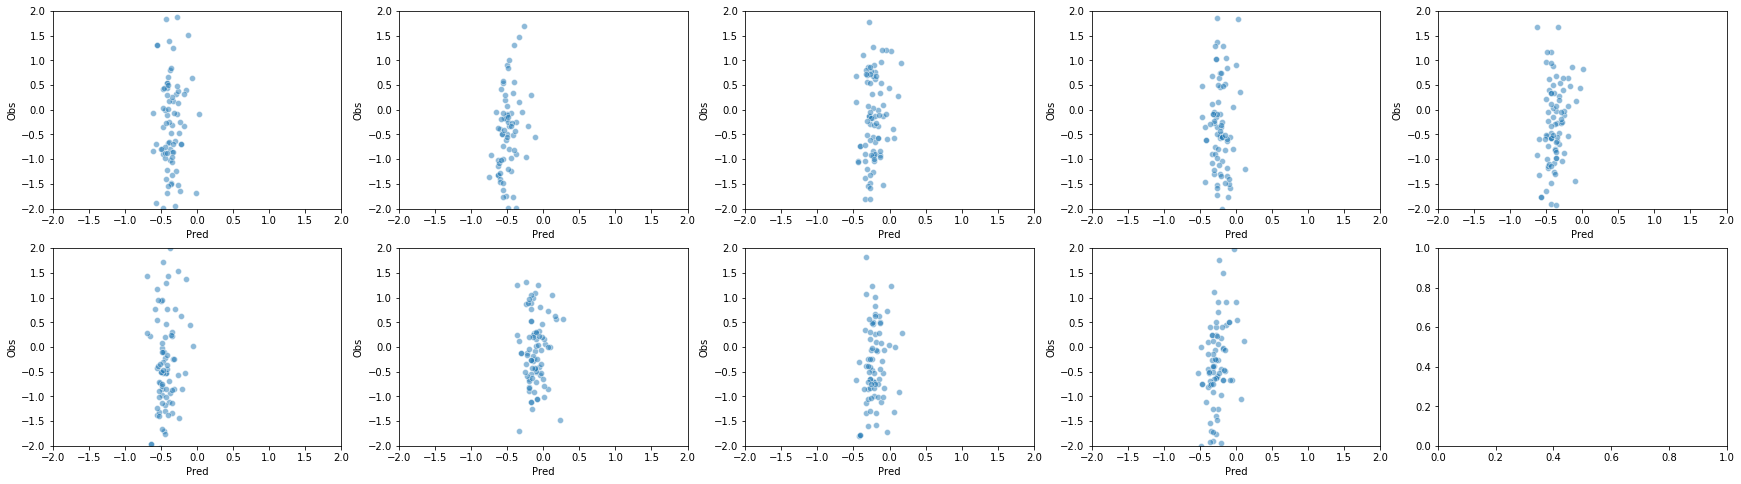

In [109]:
f, axes = plt.subplots(2, 5,figsize=(30,8))
for i in range(len(top)):
    index = top[i]
    ax = sns.scatterplot(x='pred', y='obs', data={'obs':y_true[:,index],'pred':y_pred[:,index]}, ax = axes[int(i/5)][int(i%5)], alpha = 0.5)
    ax.set(xlim=(-2,2),ylim=(-2,2), xlabel='Pred',ylabel='Obs',title="")

Get weights for the model

In [110]:
for layer in models['Muscle - Skeletal'].layers:
    print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_8'} []
{'batch_input_shape': (None, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_7'} []
{'name': 'dense_11', 'trainable': True, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[-0.00582494],
       [ 0.00322245],
       [-0.00924307],
       [ 0.00212794],
       [-0.02831711],
       [-0.0286306 ],
       [-0.01430988],
       [ 0.02987093],
       [ 0.02455025],
       [ 0.02761936]], dtype=float32), array([0.36136013], dtype=float32)]
{'name': 'dense_10', 'trainable': True, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initia

Other trials

In [19]:
# g=1 indiv1 P1 Q1
#     indiv2 P2 Q1
#....
# g=2 indiv1 P1 Q2
#     indiv2 P2 Q2
#
#
#

# Y train
# train samples - ys_train = indiv x genes
y = ys_train.T.flatten()

g_times = Q.shape[0]
indiv_times = xs_pca.shape[0]

# X train  - individual effect
# repeat P matrix g-times
X_reg_indiv = np.tile(xs_pca,(g_times,1))

# X train - gene effect
# repeat Q matrix such invididuals x gene_i, i = 0,20000
X_reg_gene = np.tile(Q[0,:],(indiv_times,1))
for i in range(1,g_times):
    X_reg_gene = np.append(X_reg_gene, np.tile(Q[i,:],(indiv_times,1)), axis=0)
 

In [28]:
# X train - cooperative fitting model    
X = np.append(X_reg_indiv, X_reg_gene, axis=1)

In [22]:
X_reg_gene.shape, y.shape, X_reg_indiv.shape

((4385040, 10), (4385040,), (4385040, 10))

In [23]:
xs_pca.shape, g_times, indiv_times

((220, 10), 19932, 220)

In [56]:
y_indiv_effect = 0
y_gene_effect = 0

reg_indiv = LinearRegression()
reg_genes = LinearRegression(fit_intercept=False)

alphas = np.zeros(P.shape[1])
betas = np.zeros(Q.shape[1])

while(True):
    ####################### individual effect ####################    

    # fit with intercept (this is the beta_0)
    reg_indiv.fit(X_reg_indiv, y - y_gene_effect)    
    # print("Error indiv effect")
    # print(sk.metrics.mean_absolute_error(alphas, reg_indiv.coef_))
    # print(beta_zero - reg_indiv.intercept_)
    alphas =  reg_indiv.coef_
    beta_zero = reg_indiv.intercept_

    # predict
    y_indiv_effect = reg_indiv.predict(X_reg_indiv)

    ######################## gene effect ###########################  

    # fit without intercept
    reg_genes.fit(X_reg_gene, y - y_indiv_effect)
    # print("Error gene effect")
    # print(sk.metrics.mean_absolute_error(betas, reg_genes.coef_))
    betas =  reg_genes.coef_

    # predict
    y_gene_effect = reg_genes.predict(X_reg_gene)
    
    y_pred = y_gene_effect + y_indiv_effect
    print(y[:3])
    print(y_pred[:3])
    print(np.isclose(y, y_gene_effect + y_indiv_effect))

[0.01868027 0.44994068 0.36149117]
[ 0.02110336 -0.05958872  0.00923494]
[False False False ... False False False]
[0.01868027 0.44994068 0.36149117]
[ 0.02110339 -0.05958872  0.00923492]
[False False False ... False False False]
[0.01868027 0.44994068 0.36149117]
[ 0.02110339 -0.05958873  0.00923494]
[False False False ... False False False]
[0.01868027 0.44994068 0.36149117]
[ 0.02110337 -0.0595887   0.00923491]
[False False False ... False False False]


KeyboardInterrupt: 

In [51]:
model.coef_ =  np.concatenate((alphas, betas), axis=0)
model.intercept_ = beta_zero

y_pred = model.predict(X)
print(sk.metrics.mean_absolute_error(y, y_pred))  

0.733478


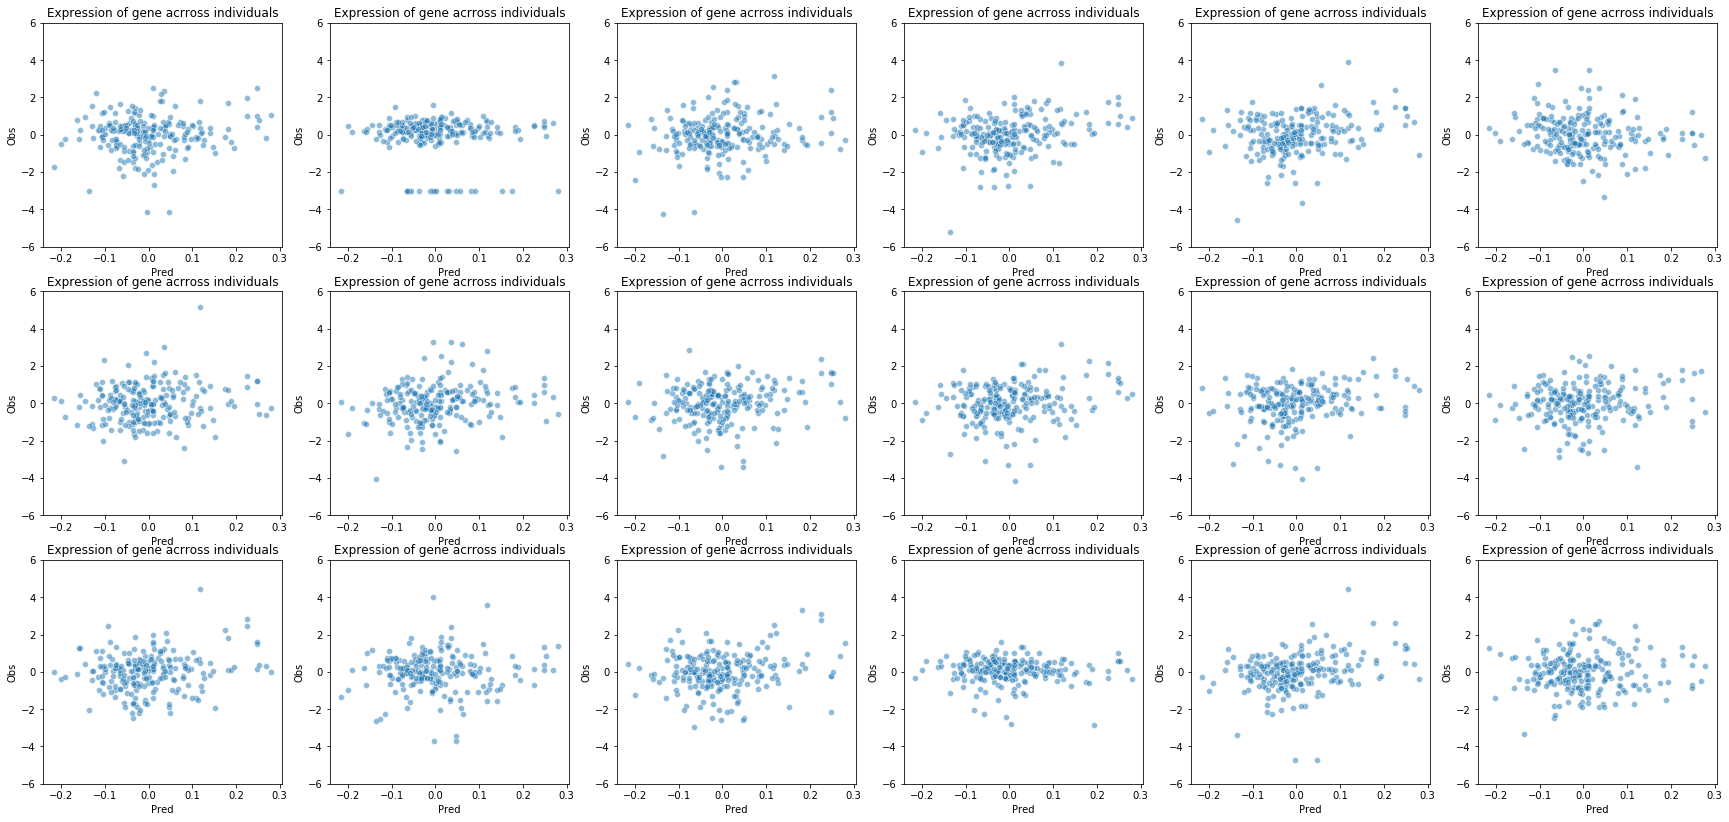

In [53]:
f, axes = plt.subplots(3, 6,figsize=(30,14))
for i in range(18):
    
    ax = sns.scatterplot(x='pred', y='obs', data={'obs':y[i*220:(i+1)*220],'pred':y_pred[i*220:(i+1)*220]}, ax = axes[int(i/6)][int(i%6)], alpha = 0.5)
    ax.set(ylim=(-6,6), xlabel='Pred',ylabel='Obs',title="Expression of gene acrross individuals")

In [21]:


####################### individual effect ####################    
reg_indiv = SGDRegressor(max_iter=100, tol=1e-10, fit_intercept=True)
    for i in range(y.shape[1]):
        reg_indiv.partial_fit(xs_pca, y[:,i])
alphas =  reg_indiv.coef_
print("Alpha weights",alphas)

# predict 
y_indiv_effect = np.tile(reg_indiv.predict(xs_pca).reshape(-1,1),(1,y.shape[1]))

######################## gene effect ###########################  
reg_genes = SGDRegressor(max_iter=100, tol=1e-10, fit_intercept=False)

for ep in range(epochs):
    for i in range(Q.shape[0]):
        X = np.tile(Q[i,:],(y.shape[0],1))
        reg_genes.partial_fit(X, y[:,i])

betas = reg_genes.coef_
print("Beta weights",betas)

# predict
y_gene_effect = np.zeros(y.shape)
for i in range(y.shape[1]):
    gene_eff = np.asscalar(reg_genes.predict(Q[i,:].reshape(1,-1)))
    y_gene_effect[:,i] = np.repeat(gene_eff, y.shape[0])

    
learning_rate = 0.01
converged = False

for i in range(30):
    print(i)
    epochs = 10    
      
    ######################## individual effect ####################    
    for ep in range(epochs):
        for i in range(y.shape[1]):
            reg_indiv.partial_fit(xs_pca, y[:,i] - y_gene_effect[:, i])    

    
    ######################## gene effect ########################  
    for ep in range(epochs):
        for i in range(Q.shape[0]):
            X = np.tile(Q[i,:],(y.shape[0],1))
            reg_genes.partial_fit(X, y[:,i] - y_indiv_effect[:, i])
    
    ######################## update weights ####################    
    print("Alpha weights before",alphas)    
    # update alphas
    alphas -= deriv_function(alphas,reg_indiv.coef_, len(alphas)) * learning_rate
    reg_indiv.coef_ = alphas
    print("Alpha weights after",alphas) 
    
    print("Beta weights before",betas)                              
    # update betas
    betas -= deriv_function(betas,reg_genes.coef_, len(betas)) * learning_rate
    reg_genes.coef_ = betas
    print("Beta weights after",betas)
    
          
    # predict 
    y_indiv_effect = np.tile(reg_indiv.predict(xs_pca).reshape(-1,1),(1,y.shape[1]))
    
    # predict
    y_gene_effect = np.zeros(y.shape)
    for i in range(y.shape[1]):
        gene_eff = np.asscalar(reg_genes.predict(Q[i,:].reshape(1,-1)))
        y_gene_effect[:,i] = np.repeat(gene_eff, y.shape[0])      
   
    
    mae = sk.metrics.mean_absolute_error(y, y_indiv_effect + y_genes_effect, multioutput='uniform_average')
    print(mae)
    
    error = deriv_function_output(y, y_pred, len(y_pred)) * learning_rate
    reg_indiv.coef_ -= error
    reg_genes.coef_ -= error
    
    
    
        

TypeError: __init__() got an unexpected keyword argument 'max_iter'

Use LinearRegression to find the alphas and betas

In [83]:
y = ys_train

####################### individual effect ####################    
reg_indiv = LinearRegression()
reg_indiv.fit(xs_pca, y)
y_indiv_effect = reg_indiv.predict(xs_pca)
alphas = np.random.rand(reg_indiv.coef_.shape[0]*reg_indiv.coef_.shape[1]).reshape(reg_indiv.coef_.shape)
# alphas = reg_indiv.coef_
# alphas =  np.mean(reg_indiv.coef_,axis=0)
# print("Alpha weights",alphas)

####################### gene effect ####################    
betas_list = np.array((Q.shape[1],y.shape[1]))
reg_genes = RidgeCV()
reg_genes.fit(Q, y.T)
y_genes_effect = reg_genes.predict(Q)
# betas = reg_genes.coef_
betas = np.random.randn(reg_genes.coef_.shape[0]*reg_genes.coef_.shape[1]).reshape(reg_genes.coef_.shape)

# betas = np.mean(reg_genes.coef_,axis=0)
# print("Beta weights",betas)

learning_rate = 0.3
converged = False

for i in range(100):  
      
    ######################## individual effect ####################    
    reg_indiv.fit(xs_pca, y-y_genes_effect.T)

    ######################## gene effect ########################  
    reg_genes.fit(Q, y.T - y_indiv_effect.T)

    ######################## update weights ####################
#     alphas -= deriv_function(alphas.squeeze().reshape(-1,1), reg_indiv.coef_.squeeze().reshape(-1,1), alphas.shape[0]*alphas.shape[1]) * learning_rate
#     betas -= deriv_function(betas.squeeze().reshape(-1,1), reg_genes.coef_.squeeze().reshape(-1,1), betas.shape[0]*betas.shape[1]) * learning_rate
    
    error = deriv_function_output(y.squeeze().reshape(-1,1), (y_indiv_effect + y_genes_effect.T).squeeze().reshape(-1,1), y.shape[0]*y.shape[1]) * learning_rate
    alphas -= error
    betas -= error
   
    
    reg_indiv.coef_ = alphas
    reg_genes.coef_ = betas

    y_indiv_effect = reg_indiv.predict(xs_pca)
    y_genes_effect = reg_genes.predict(Q) 
    
    mae = sk.metrics.mean_absolute_error(y, y_indiv_effect + y_genes_effect.T, multioutput='uniform_average')
    print(mae)

64.4988901613958
42.66732923346911
42.660220196542994
42.66026426172369
42.66025998392653
42.66026397132566
42.66025998602967
42.660263971312794
42.6602599860181
42.660263971315324
42.6602599860064
42.66026397131785
42.66025998599471
42.66026397132038
42.660259985983025
42.66026397132291
42.66025998597134
42.66026397132545
42.66025998595964
42.66026397132797
42.66025998594795
42.660263971330515
42.66025998593627
42.660263971333045
42.660259985924576
42.66026397133557
42.66025998591288
42.6602639713381
42.66025998590119
42.660263971340626
42.660259985889496
42.660263971343156
42.6602599858778
42.66026397134569
42.66025998586611
42.66026397134823
42.66025998585443
42.66026397135076
42.660259985842735
42.660263971353295
42.660259985831054
42.660263971355825
42.660259985819366
42.660263971358354
42.66025998580767
42.66026397136089
42.66025998579598
42.66026397136343
42.660259985784286
42.66026397136596
42.660259985772605
42.660263971368494
42.66025998576091
42.66026397137102
42.66025998574

In [84]:
betas = np.mean(reg_genes.coef_,axis=0)
print("Beta weights",betas)
alphas = np.mean(reg_indiv.coef_,axis=0)
print("Alphas weights",alphas)

Beta weights [ 0.01895354  0.02210468 -0.11102061  0.04245279  0.01604384 -0.05561803
 -0.01181623  0.08357091  0.02940567 -0.1316881 ]
Alphas weights [0.4991984  0.49427687 0.49376942 0.49788341 0.49663496 0.49736938
 0.49569301 0.49996273 0.49236325 0.4954699 ]


In [70]:
y_indiv_effect.shape,y_genes_effect.shape

((220, 19932), (19932, 220))

In [71]:
# fit tissue coeficient
X = (y_indiv_effect + y_genes_effect.T).reshape(-1,1)
reg_fit_residual = RidgeCV().fit(X,y.reshape(-1,1))
beta_zero_tissue = np.asscalar(reg_fit_residual.coef_)

In [72]:
# build big model:
model = LinearRegression()
model.coef_ = np.concatenate((np.array([beta_zero_tissue]), alphas, betas), axis=0)
model.intercept_ = reg_fit_residual.intercept_ + np.mean(reg_indiv.intercept_) + np.mean(reg_genes.intercept_)

Build the parameters for the big model

In [46]:
# build big model:
model = LinearRegression()
model.coef_ = np.concatenate((alphas, betas), axis=0)
model.intercept_ = np.mean(reg_indiv.intercept_) + np.mean(reg_genes.intercept_)

Predict using the Big model

In [73]:
# X = np.zeros((xs_pca.shape[0],P.shape[1]+Q.shape[1]))
X = np.zeros((xs_pca.shape[0],1+P.shape[1]+Q.shape[1]))
y_pred = np.zeros(y.shape)
for gene in range(y.shape[1]):
    for sample in range(xs_pca.shape[0]):
#         X[sample,:] = np.c_[np.array([1]).reshape(1,1),xs_pca[sample,:].reshape(1,-1),Q[gene,:].reshape(1,-1),np.array([epsilon[sample,gene]]).reshape(1,1)]
        X[sample,:] = np.c_[np.array([1]).reshape(1,1), xs_pca[sample,:].reshape(1,-1),Q[gene,:].reshape(1,-1)]
    y_pred[:,gene] = model.predict(X)

In [83]:
rsquare = []
for i in range(y.shape[0]): rsquare.append(sk.metrics.r2_score(y[:,i], y_pred[:,i]))
print(np.mean(rsquare),np.max(rsquare),np.min(rsquare))

-1.5511970071591132 -0.9167153582182401 -2.0579571341499574


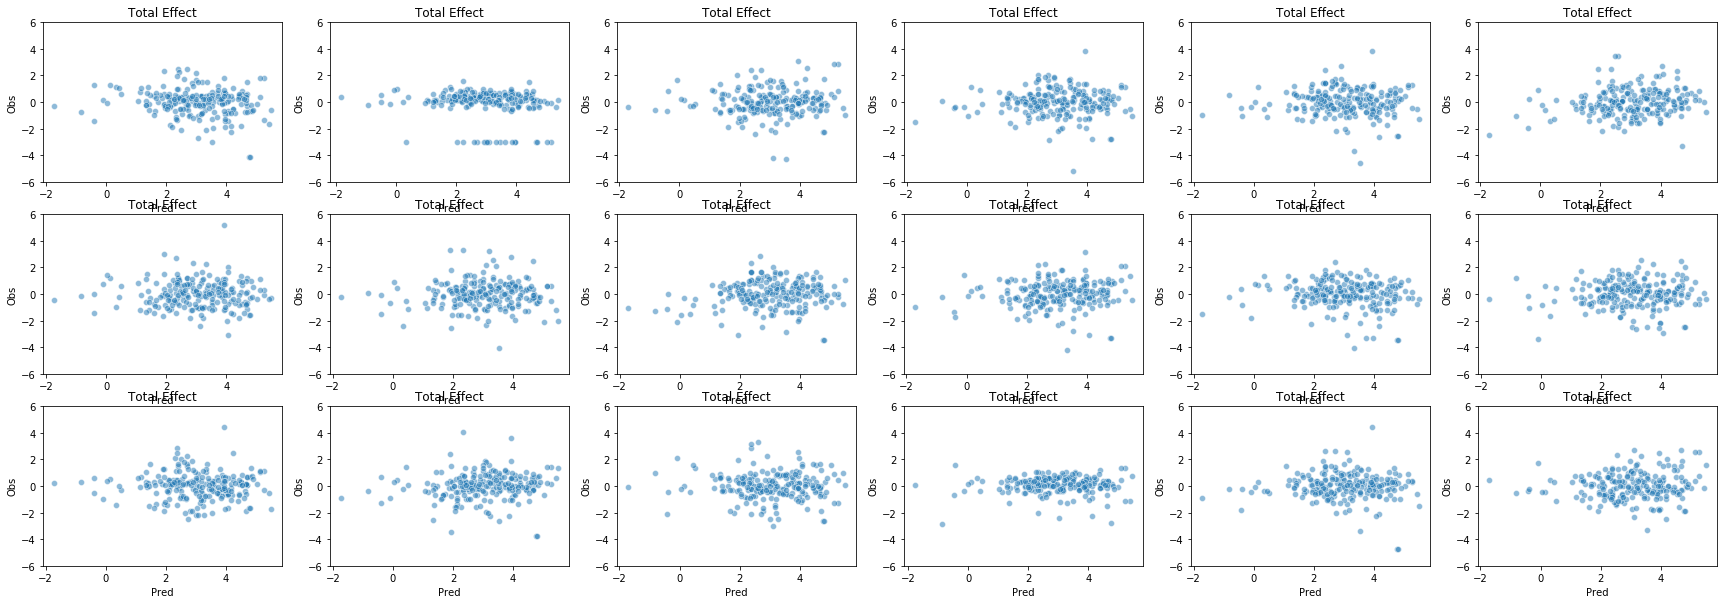

In [85]:
f, axes = plt.subplots(3, 6,figsize=(30,10))
for i in range(18):
    
    ax = sns.scatterplot(x='pred', y='obs', data={'obs':y[:,i],'pred':y_pred[:,i]}, ax = axes[int(i/6)][int(i%6)], alpha = 0.5)
    ax.set(ylim=(-6,6), xlabel='Pred',ylabel='Obs',title="Total Effect")
    
#     ax = sns.scatterplot(x='pc1', y='obs', data={'pc1':X[:,0],'obs':y[:,i]}, ax = axes[int(i/6)][int(i%6)], alpha = 0.5)
#     ax.set(ylim=(-6,6), xlabel='PC1',ylabel='Obs',title="Fit")
#     ax.plot(X[:0], y_pred[:,1], color="red")   

In [43]:
from keras.layers import Input, Dense, Add
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics as m
import pydot
%matplotlib inline

In [52]:
## gene effect
q = Input(shape=(Q.shape[1],))
gene_effect = Dense(units=1)(q)

## individual effect
p = Input(shape=(xs_pca.shape[1],))
indiv_effect = Dense(units=1)(p)

added = Add()([indiv_effect, gene_effect])
out = Dense(1)(added)

model = Model(inputs=[p, q], outputs=out)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mae'])

In [53]:
xs_pca_extended = np.tile(xs_pca[0,:],(ys_train.shape[1],1))
for i in range(1,xs_pca.shape[0]):
    xs_pca_extended = np.append(xs_pca_extended, np.tile(xs_pca[i,:],(ys_train.shape[1],1)), axis=0)
xs_pca_extended.shape

(4385040, 50)

In [54]:
[X_train_p, X_train_q], Y_train = [xs_pca_extended, np.tile(Q,(ys_train.shape[0],1))],ys_train.reshape(-1,1)
# X_valid, Y_valid = np.tile(Q,(ys_valid.shape[0],1)),ys_valid.reshape(-1,1)

In [ ]:
model.fit([X_train_p, X_train_q], Y_train,
                epochs=100,
                batch_size=500,
                shuffle=True)


Epoch 1/10
3600740/4385040 [=======================>......] - ETA: 2s - loss: 0.9639 - mean_absolute_error: 0.7229

In [56]:
y_pred = model.predict([X_train_p, X_train_q])

In [57]:
y_pred = y_pred.reshape(220,-1)

In [58]:
for layer in model.layers:
    print(layer.get_config(), layer.get_weights())


{'batch_input_shape': (None, 50), 'dtype': 'float32', 'sparse': False, 'name': 'input_6'} []
{'batch_input_shape': (None, 50), 'dtype': 'float32', 'sparse': False, 'name': 'input_5'} []
{'name': 'dense_8', 'trainable': True, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[ 0.01671067],
       [ 0.02041184],
       [ 0.00318745],
       [-0.05027566],
       [-0.1186374 ],
       [ 0.08723627],
       [ 0.12440085],
       [-0.16774455],
       [ 0.09682988],
       [ 0.04980118],
       [ 0.12868279],
       [ 0.03922706],
       [ 0.14331207],
       [ 0.10788825],
       [-0.16088419],
       [ 0.29594493],
       [-0.10862478],
       [

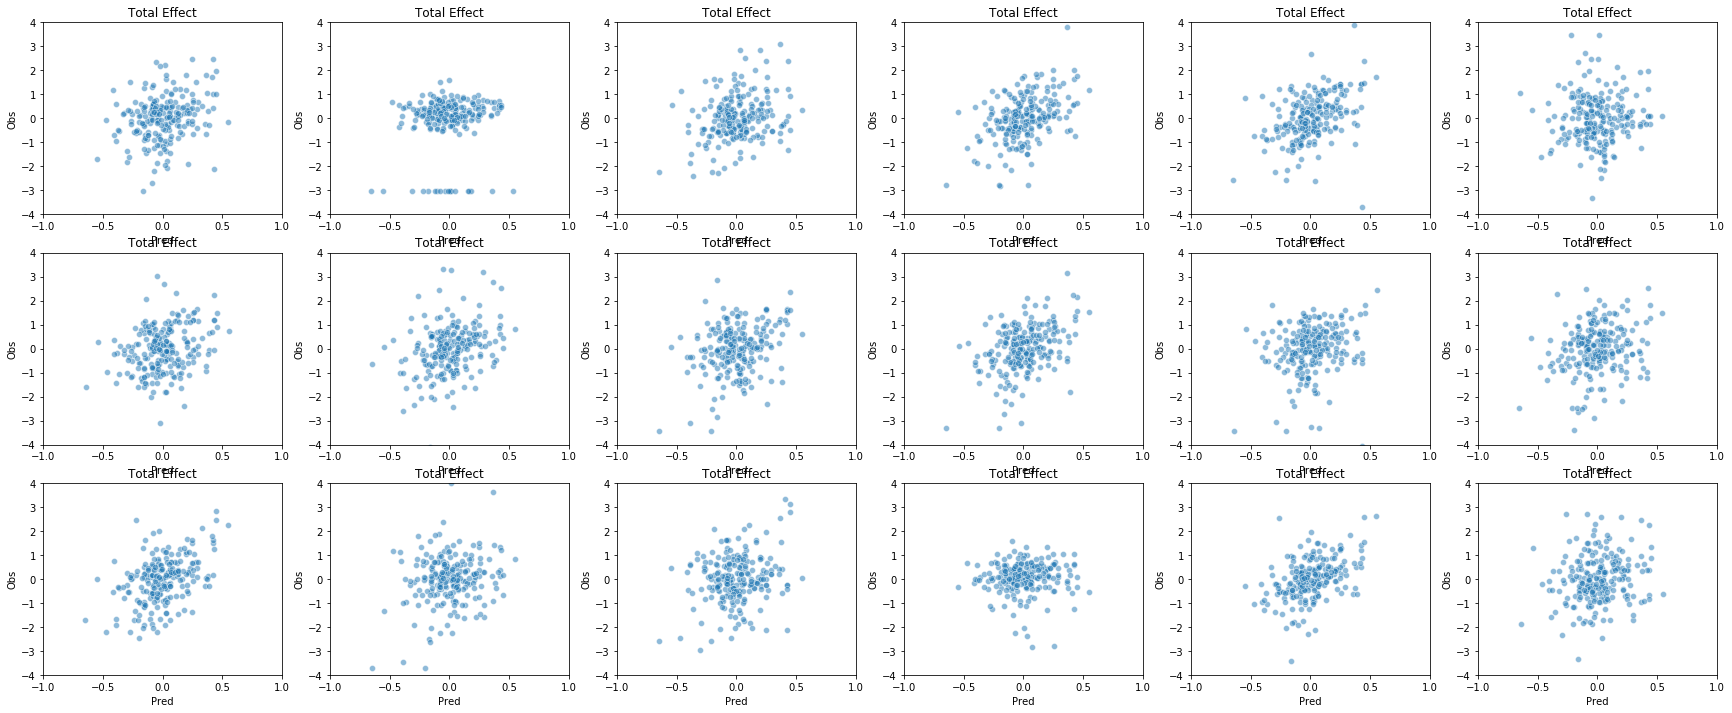

In [63]:
f, axes = plt.subplots(3, 6,figsize=(30,12))
for i in range(18):
    
    ax = sns.scatterplot(x='pred', y='obs', data={'obs':ys_train[:,i],'pred':y_pred[:,i]}, ax = axes[int(i/6)][int(i%6)], alpha = 0.5)
    ax.set(xlim=(-1,1),ylim=(-4,4), xlabel='Pred',ylabel='Obs',title="Total Effect")